In [31]:
%matplotlib inline
%run forecast.py

In [13]:
# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH SarabunPSK')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Import Data

In [14]:
hml = dict(data=read_price('hml'), shortname='ข้าวหอมมะลิ', fullname='ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา')

wht = dict(data=read_price('wht'), shortname='ข้าวเจ้าขาว', fullname='ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา')
glu = dict(data=read_price('glu'), shortname='ข้าวเหนียว', fullname='ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา')
hml['data'].meta = SimpleNamespace()
hml['data'].meta.shortname = 'หอมมะลิ'

hml['data'].name = 'hml'
wht['data'].name = 'wht'
glu['data'].name = 'glu'
prices = [hml, wht, glu]

In [15]:
pledg_idx = pd.date_range('2011-10', '2014-2', freq='MS')
exo = pd.DataFrame(index = wht['data'].index)
exo['pledge'] = 0
exo.loc['2011-10':'2014-2'] = 1

# Visualization and Decomposition

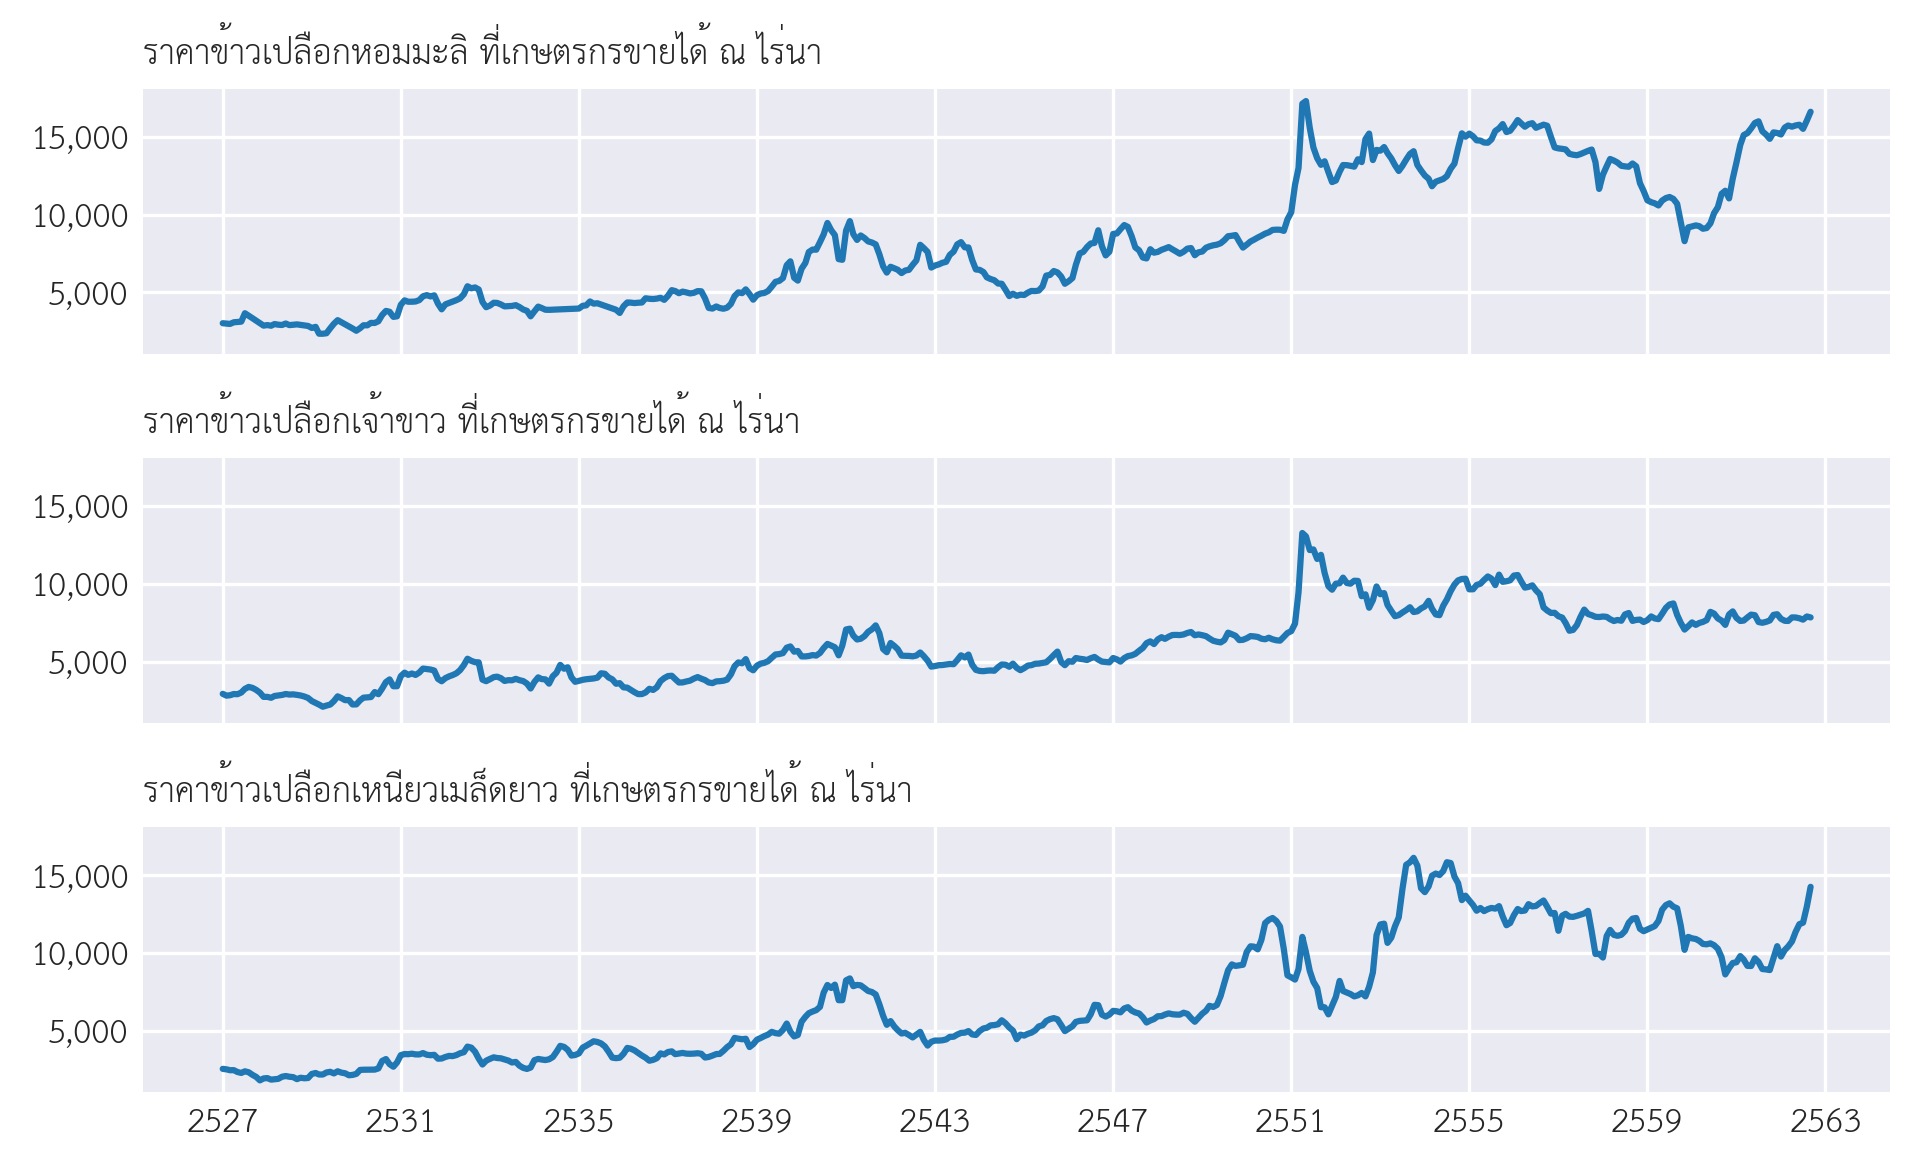

In [16]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6.5, 4))
# fig.subplots_adjust(hspace=1)
for i, price in enumerate(prices):
    ax[i].plot(price['data'].index, price['data'].value)
    ax[i].set_title(price['fullname'], loc='left')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(thai_year))
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
# fig.savefig('../figure/01_price plot.png', dpi=300)

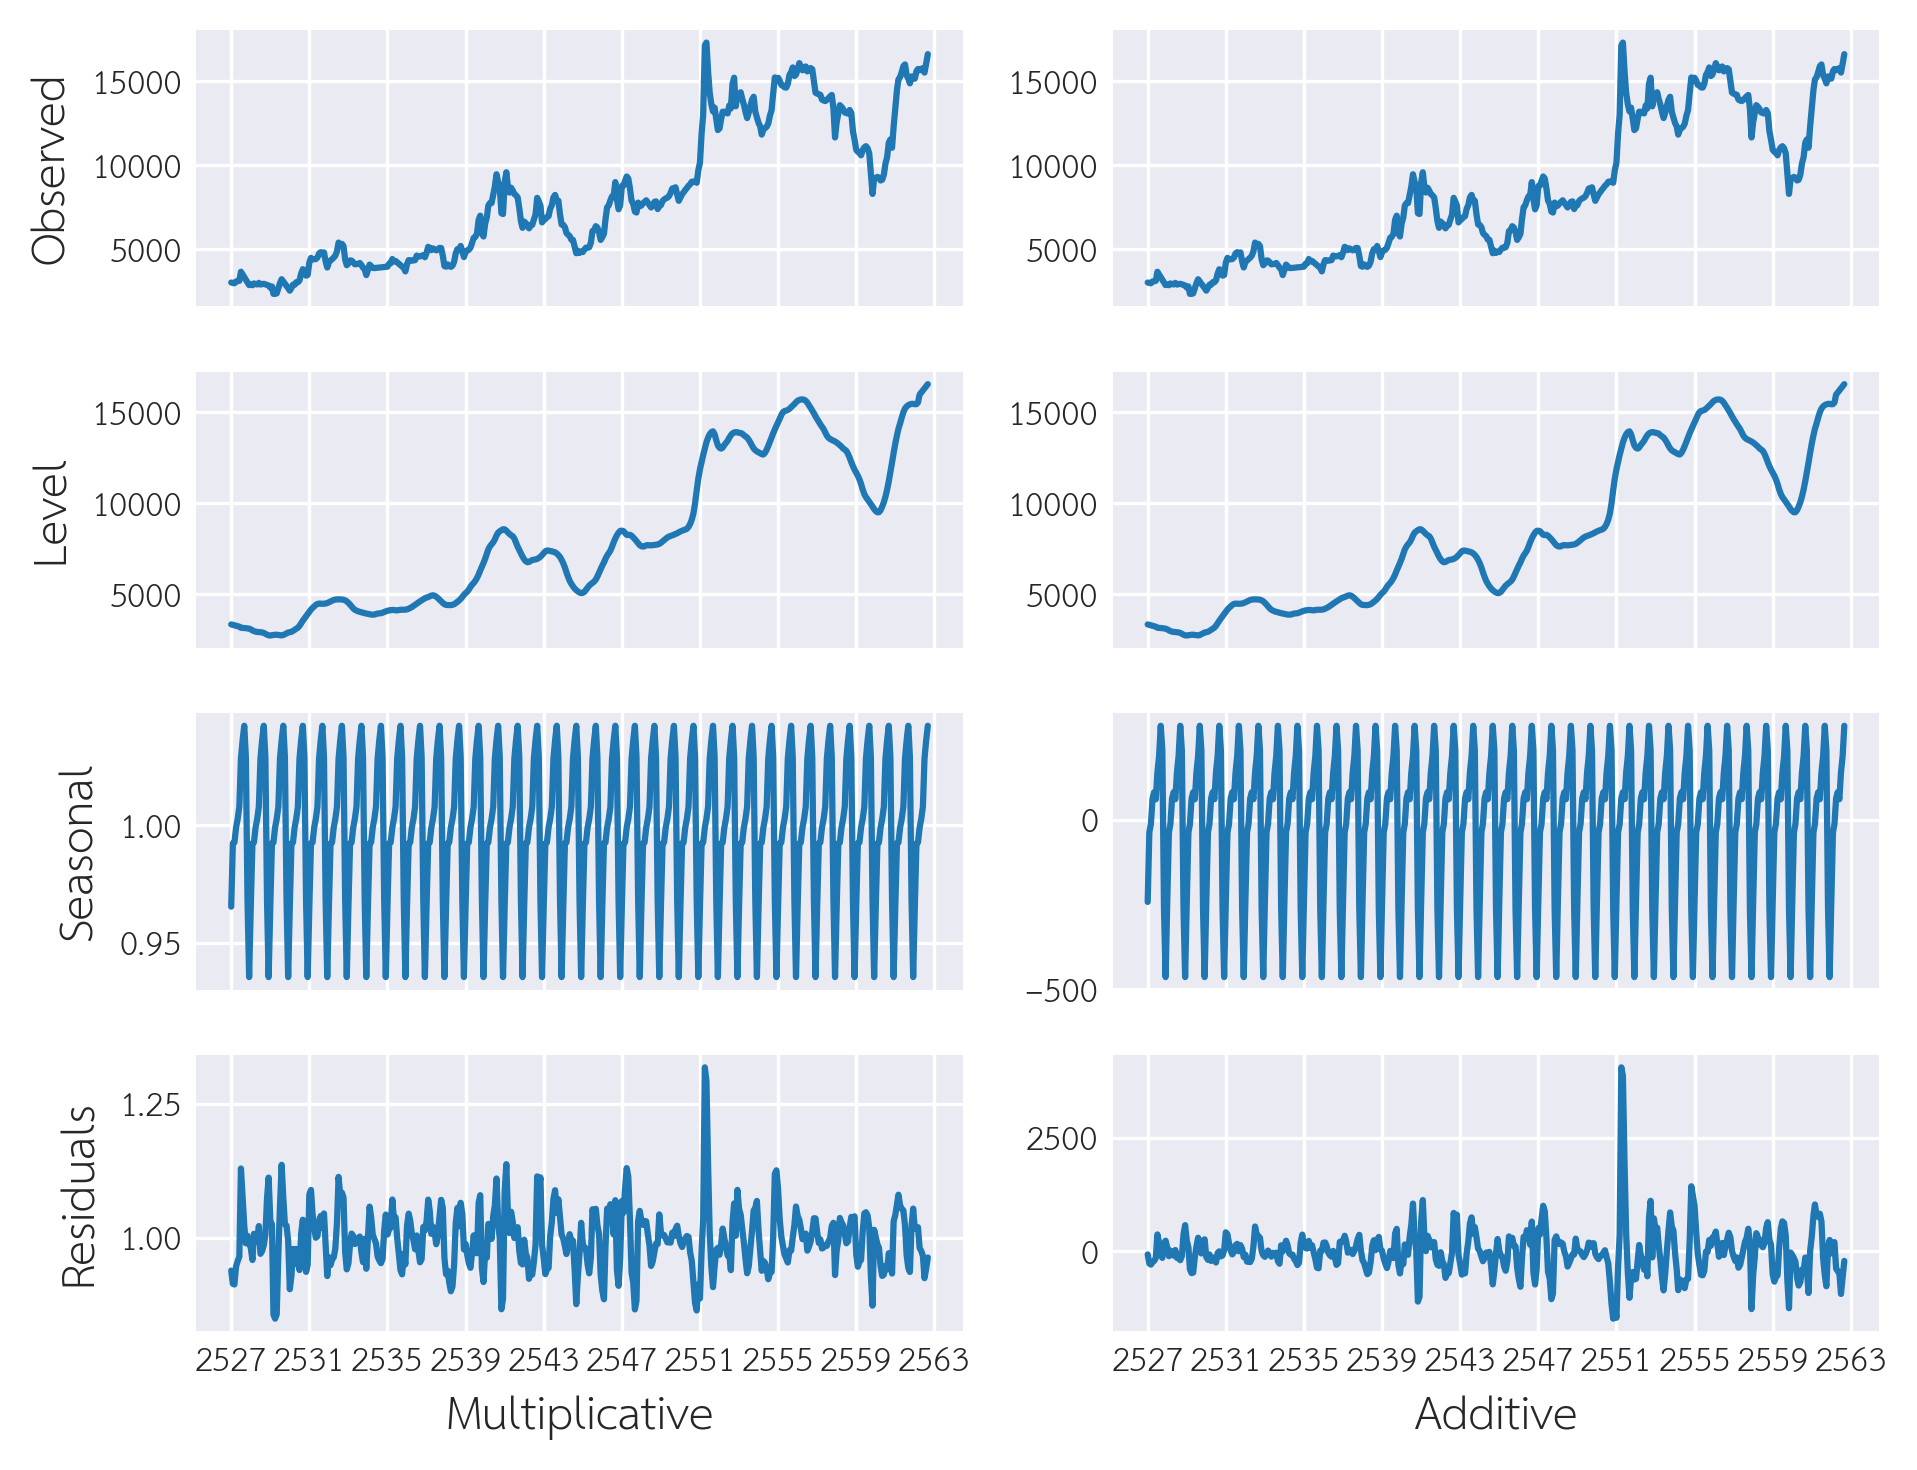

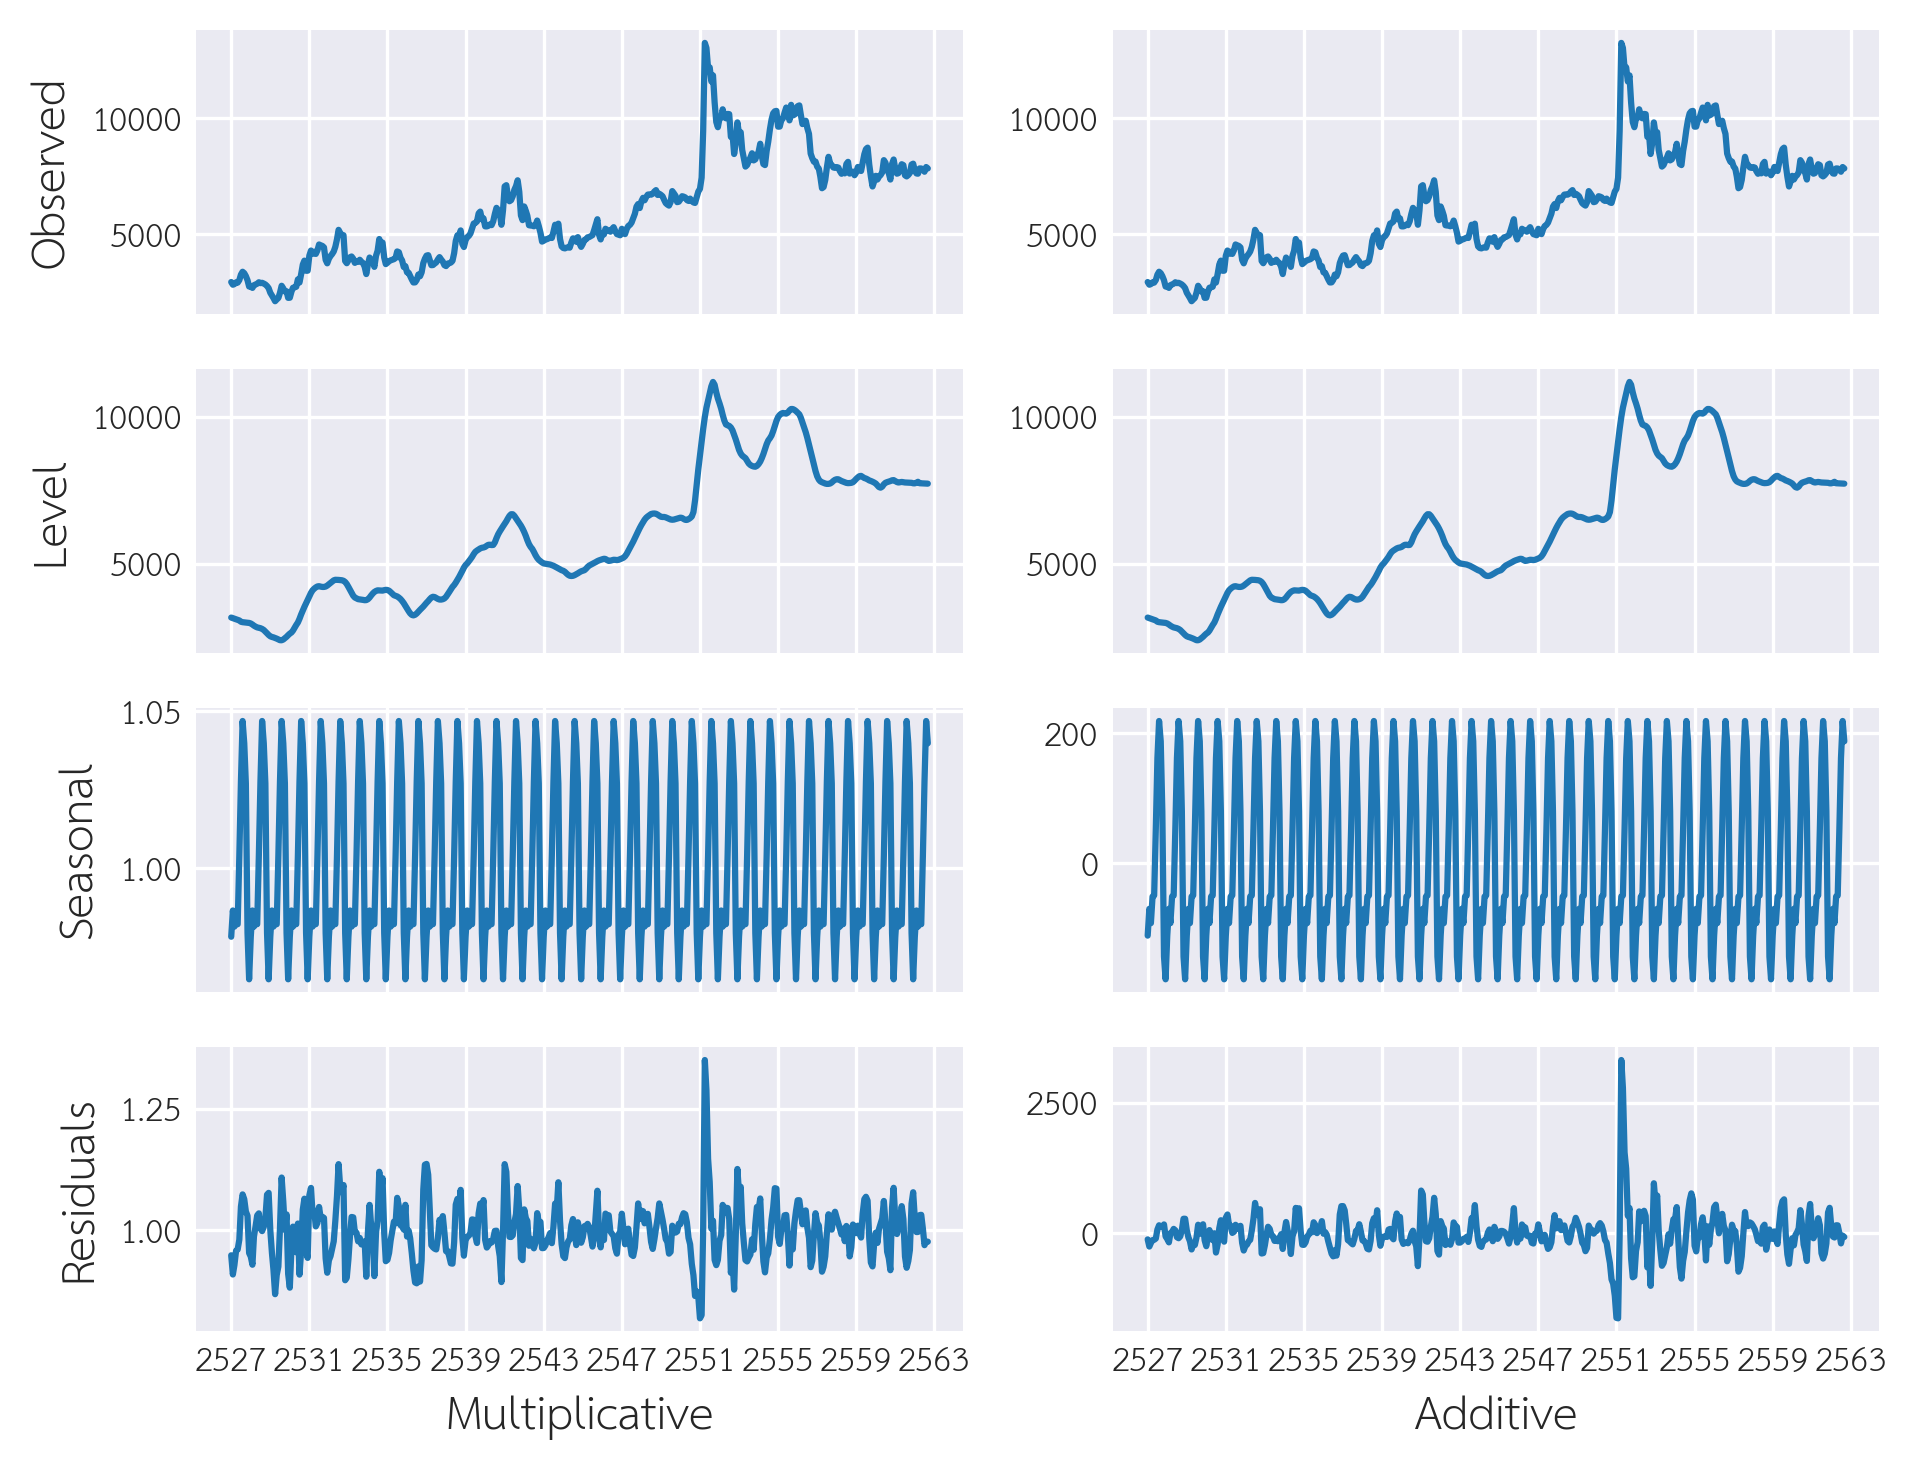

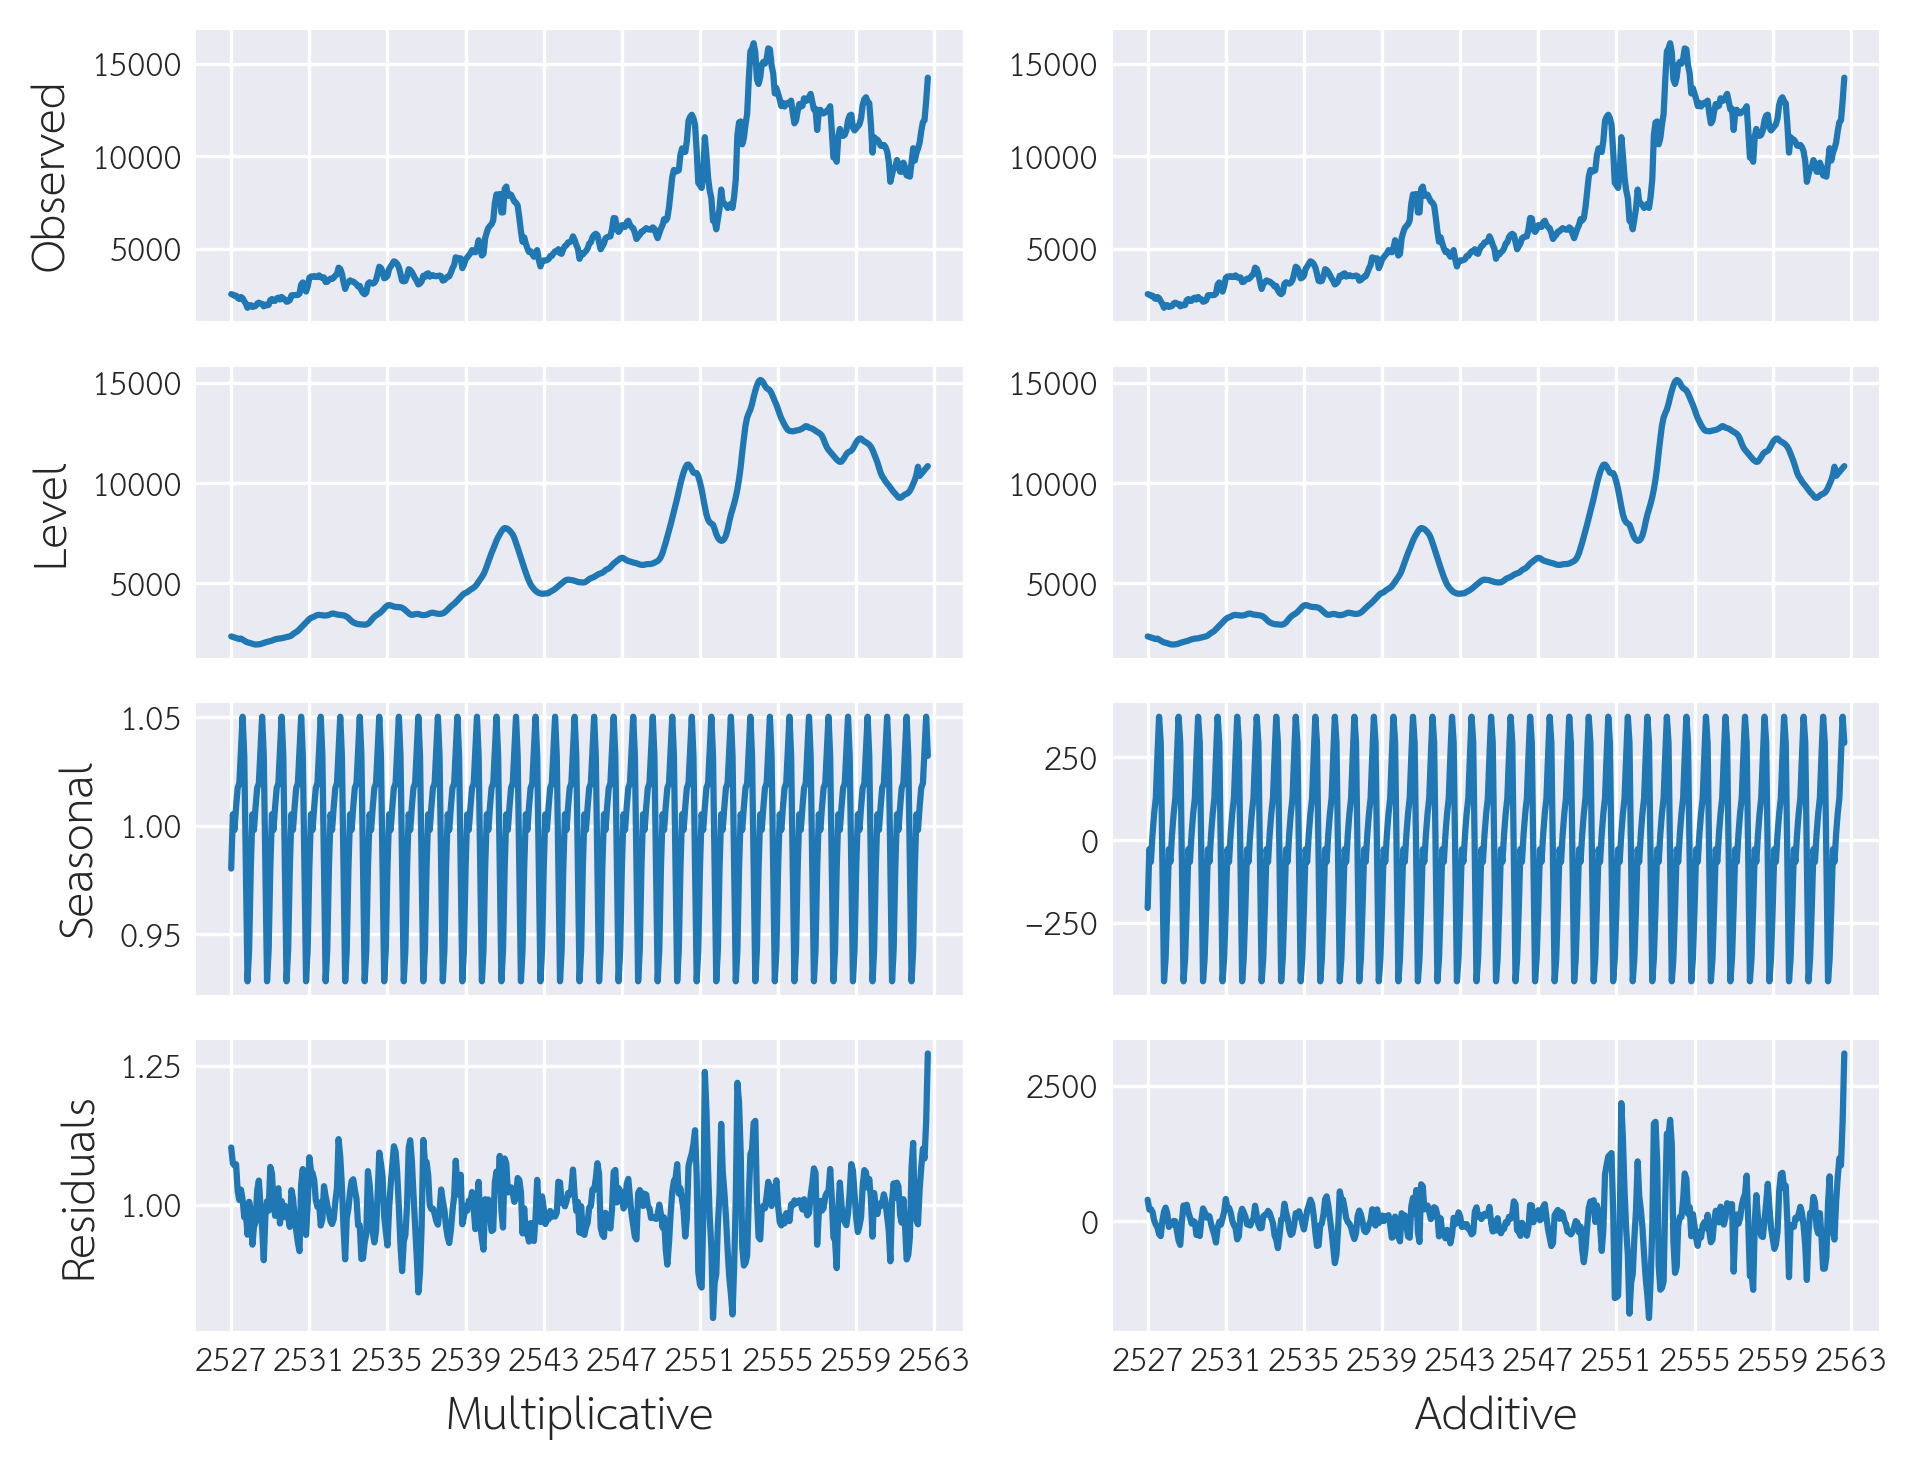

In [22]:
for price in prices:
    ser = price['data']
#     xlim = mdates.date2num([rice['data'].index[0], rice['data'].index[-1]])
    decom_mul = seasonal_decompose(ser.value,
                                   model='mul',
                                   extrapolate_trend='freq',
                                  )
    decom_add = seasonal_decompose(ser.value,
                                   model='add',
                                   extrapolate_trend='freq',
                                  )
    
    fig, axs = plt.subplots(4, 2, sharex=True, figsize=(6.5, 5))
    
    axs[0,0].plot(decom_mul.observed.index, decom_mul.observed)
    axs[1,0].plot(decom_mul.trend)
    axs[2,0].plot(decom_mul.seasonal)
    axs[3,0].plot(decom_mul.resid)
    
    axs[0,1].plot(decom_add.observed.index, decom_add.observed)
    axs[1,1].plot(decom_add.trend)
    axs[2,1].plot(decom_add.seasonal)
    axs[3,1].plot(decom_add.resid)
    for ix, i in enumerate(['Observed', 'Level', 'Seasonal', 'Residuals']):
        axs[ix, 0].set(ylabel=i)
    for ax in axs.flat:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(thai_year))
#     ax.label_outer()  
#     axs[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#     axs[1,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#     ax[0].set_xlim(xlim)
    axs[3,0].set_xlabel('Multiplicative')
    axs[3,1].set_xlabel('Additive')
    plt.tight_layout()
#     fig.savefig(f'../figure/02_{ser.name} decomp.png', dpi=300)

# Stationary Test

In [28]:
def test_stationary(df, name=None, col='value'):
    """
    Stationary test of a series
    Input: A dataframe with a specific column
    """
    if name == None:
        name = df.name
    col_names = ['name', 'level', 'adf_stat', 'adf_pval', 'kpss_stat', 'kpss_pval']
    level = df[col]
    diff1 = df[col].diff().dropna()

    result = []
    result.append([name, 'level', *adfuller(level)[:2], *kpss(level)[:2]])
    result.append([name, 'diff1', *adfuller(diff1)[:2], *kpss(diff1)[:2]])

    return pd.DataFrame(result, columns=col_names).set_index(['name', 'level']).round(4)

In [29]:
res_stationary = pd.DataFrame()
for price in prices:
    res_stationary = res_stationary.append(test_stationary(price['data']))
res_stationary

adf_stat  adf_pval  kpss_stat  kpss_pval
name level                                          
hml  level   -0.9293    0.7782     2.0721     0.0100
     diff1  -13.8108    0.0000     0.0558     0.1000
wht  level   -1.5430    0.5121     1.9118     0.0100
     diff1   -6.0760    0.0000     0.0467     0.1000
glu  level   -0.8153    0.8146     2.0079     0.0100
     diff1   -5.7040    0.0000     0.0433     0.1000

# Prepare Data

In [35]:
for price in prices:
    supervised = series2supervised(price['data'])
    scaler, scaled = data_transform(price['data'])
    supervised_scaled = series2supervised(scaled)
    price['scaler'] = scaler
    price['scaled'] = scaled
    price['sup'] = supervised
    price['sup_scaled'] = supervised_scaled
    price['start_test'] = ['2010-12', '2012-12', '2014-12'] # before/during/after pledging scheme
#     price['N'] = price['data'].shape[0]
# data_inverse(np.array([[.8,.85,.89]]), hml['data'], scaler, 300)

# Exponential Smoothing

In [ ]:
def hws(df, start_test='2012-12', use_boxcox=False):
    """
    Create a Holt Winter's model
    Input: a dictionary contains data and etc
    Output: Holt Winter's Seasonal method where trend = additional damped trend, seasonal = multiplicative
    """
    train = df.
    return ExponentialSmoothing(df[:n_train],
                                trend='add', damped=True,
                                seasonal='mul', seasonal_periods=12
                               ).fit(use_boxcox=use_boxcox)

def rolling_hws(dt, n_train=348, n_fcast=6, use_boxcox=False):
    """
    Input: a dictionary containing the dataframe
    Ouput: a rolling multi-period forecast 
    """
    N = dt['N']
    n_test = N - n_train
    df = dt['data']
    
    fcast = np.empty((n_test+1, n_fcast))
    for i in range(n_test+1):
        fcast[i] = hws(df, n_train+i, use_boxcox).forecast(n_fcast)
    return pd.DataFrame(fcast,
                        columns=[f'fcast{i}t' for i in range(1, n_fcast+1)],
                        index=df.index[n_train-1:])

In [ ]:
fcast_hws = dict()
for price in prices:
    fcast_hws[price['abb']] = rolling_hws(price)
    price['fcast_hws'] = fcast_hws[price['abb']]
joblib.dump(fcast_hws, 'fcast_hws.pkl')

In [ ]:
plot_fcast(hml, method='hws')

# ARIMA

In [ ]:
def arima(df, n_train=None, use_exo=True):
    """
    Create an auto ARIMA model
    """
    return pm.auto_arima(df[:n_train],
                         exogenous=exo.iloc[:n_train] if use_exo==True else None,
                         start_p=0, start_q=0, # starting p, q
                         max_p=6, max_q=6, # maximum p, q
                         start_P=0, start_Q=0, # starting P, Q
                         m=12, seasonal=True, # monthly data
                         d=1, D=0, # first difference is sufficient suggested by test
                         information_criterion='aic',
                        )

def rolling_arima(dt, n_train=348, n_fcast=6, use_exo=True, learning_rate=None):
    """
    Input: a dictionary containing the dataframe
    Ouput: a rolling multi-period forecast 
    """
    N = dt['N']
    n_test = N - n_train
    df = dt['data']
    
    fcast = np.empty((n_test+1, n_fcast))
    orders = []
    
    # กรณี p,q,P,Q sarima ถูกกำหนดโดย training data แล้ว fix
    if learning_rate is None:
        # estimate arima โดยใช้ train dataset
        model = arima(df, n_train, use_exo=use_exo)
        orders.append(str(model.order + model.seasonal_order))
        
        # forecast
        fcast[0] = model.predict(n_fcast, exogenous=exo.iloc[n_train: n_train+n_fcast])
        
        # refit arima model โดยใช้ update method กับข้อมูลใหม่
        for i in range(n_test):
            idx = n_train+i
            if N-idx > 12:
                x = exo.iloc[idx+1:idx+n_fcast+1]
            else:
                x = np.array([0]*n_fcast).reshape(-1, 1)
            
            model = model.update(df.iloc[idx],
                                 exogenous=exo.iloc[idx].values.reshape(-1, 1) if use_exo==True else None,
                                )
            fcast[i+1] = model.predict(n_fcast,
                                       exogenous= x if use_exo==True else None,
                                      )
            orders.append(str(model.order + model.seasonal_order))
    
    res = pd.DataFrame(fcast,
                       columns=[f'fcast{i}t' for i in range(1, n_fcast+1)],
                       index=df.index[n_train-1:])
    res['orders'] = orders
    
    return res

In [ ]:
fcast_arima = dict()
for price in prices:
    fcast_arima[price['abb']] = rolling_arima(price, use_exo=False)
    price['fcast_arima'] = fcast_arima[price['abb']]
joblib.dump(fcast_arima, 'fcast_arima.pkl')

fcast_arimax = dict()
for price in prices:
    fcast_arimax[price['abb']] = rolling_arima(price, use_exo=True)
    price['fcast_arimax'] = fcast_arimax[price['abb']]
joblib.dump(fcast_arimax, 'fcast_arimax.pkl')

In [ ]:
plot_fcast(glu, method='arima')

In [ ]:
plot_fcast(glu, method='arimax')

In [ ]:
def lstm_prepossesing(df):
    n_train = int(df['data'].shape[0]*0.8)
    X = pd.DataFrame(index = df['data'].index)
    for i in range(1, 25):
         X[f'feat{i}'] = df['data'].shift(i)
    test_X = X[n_train:]
    test_y = df['data'][n_train:].values
    test_X = test_X.values.reshape(test_X.shape[0], 1, test_X.shape[1])
    train_X = X[:n_train].dropna()
    train_y = df['data'].loc[train_X.index].values
    train_X = train_X.values.reshape(train_X.shape[0], 1, train_X.shape[1])
#     train_y = y.values
    
    return train_X, train_y, test_X, test_y

In [ ]:
def lstm_prepossesing(dt):
    X = dt['sup_scaled'].filter(like='x')
    y = dt['sup_scaled'].filter(like='y')
    N = dt['N']
    n_train = 348
    n_fcast = y.shape[1]

    test_X = X[n_train:N-n_fcast]
    test_y = y[n_train:N-n_fcast].values
    test_X = test_X.values.reshape(test_X.shape[0], 1, test_X.shape[1])
    
    train_X = X[:n_train].dropna()
    train_y = y.loc[train_X.index].values
    train_X = train_X.values.reshape(train_X.shape[0], 1, train_X.shape[1])
    
    return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = lstm_prepossesing(hml)

# LSTM

In [ ]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_train = 348
train_hml = lstm_prepossesing(hml)

# สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(50) และ shape ของข้อมูล input(#rows x #features)
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (6) 
model.add(Dense(6))

model.compile(loss='mae', optimizer='adam')
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()

# train โมเดล และเก็บ log
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# # พล็อตค่า train&test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
test_y[0]

In [ ]:
model.predict(test_X)[0]

# Evaluate forecast

In [ ]:
def eval_fcast(dt, method='arima', metrics=rmse, n_forecast=6):
    """
    Evaluate forecast accuracy
    """
    actual = dt['data'].rename(columns={'value':'actual'})
    fcast  = dt[f'fcast_{method}']
    
    N = dt['N']
    n_test, n_fcast = fcast.filter(like='f').shape
    n_train = N-n_test
    n_eval = n_test-n_forecast
    df = actual.join(fcast)
    res = []
    for i in range(1, n_fcast+1):
        _ = metrics(df['actual'].iloc[n_train+i : N-n_forecast+1],
                    df[f'fcast{i}t'].shift(i)[n_train+i : N-n_forecast+1]
                   )
        res.append(_)
    return np.array(res).sum()

In [ ]:
methods = ['hws', 'arima', 'arimax']
eval_df = pd.DataFrame()
for price in prices:
    for method in methods:
        eval_df.loc[price['shortname'], method] = eval_fcast(price, method)
eval_df

# Appendix

In [ ]:
plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':300})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_acf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.price.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.price.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()


plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':300})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_pacf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.price.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.price.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()

In [ ]:
for price in prices:
    supervised = series2supervised(price['data'])
    scaler, scaled = data_transform(price['data'])
    
    
    X_train, X_test, y_train, y_test, n_train, n_test, N = split_train_test(supervised)
    price['train'] = (X_train, y_train)
    price['test']  = (X_test,  y_test)
    
    
    supervised_scaled = series2supervised(scaled)
    X_train, X_test, y_train, y_test, n_train, n_test, N = split_train_test(supervised_scaled)
    rice['train_scaled'] = (X_train, y_train)
    rice['test_scaled'] = (X_test,  y_test)
    rice['scaled'] = scaled
    rice['scaler'] = scaler
    rice['n_train'] = n_train
    rice['n_test'] = n_test
    rice['N'] = N

In [ ]:
def rolling_arima(dt, n_fcast=6, scaled=False, reselect_orders=False):
    N, n_train, n_test = dt['N'], dt['n_train'], dt['n_test']
    df = dt['data'].values
    data_transform(df)
    
    fcast = np.empty((n_test, n_fcast))
    
    # กรณี p,q,P,Q sarima ถูกกำหนดโดย training data แล้ว fix
    if reselect_orders == False:
        # สร้าง empty container สำหรับ forecast value และ orders ของ arima
        fcast = np.empty((n_test, n_fcast))
        orders = []
        
        # estimate arima โดยใช้ train dataset
        model = arima(df, n_train)
        
        # forecast
        fcast[0] = model.predict(n_fcast)
        orders.append(str(model.order + model.seasonal_order))
        
        # refit arima model โดยใช้ update method กับข้อมูลใหม่
        for i in range(1, n_test):
            model = model.update(df['data'][n_train+i:n_train+i+1])
            fcast[i] = model.predict(n_fcast)
            orders.append(str(model.order + model.seasonal_order))
            
    # กรณีหา p,q,P,Q ทุกครั้ง
    else:
        # สร้าง empty container สำหรับ forecast value และ orders ของ arima
        fcast = np.empty((n_test, n_fcast))
        orders = []
        for i in range(n_test):
            # estimate arima โดยใช้ข้อมูลจากอดีตถึงปัจจุบัน
            model = arima(df, n_train+i)
            fcast[i] = model.predict(n_fcast)
            orders.append(str(model.order + model.seasonal_order))        
    
    res = pd.DataFrame(fcast,
                       columns=[f'fcast{i}' for i in range(1,n_fcast+1)],
                       index=df['data'].index[-n_test:])
    res['orders'] = orders
    return res

In [ ]:
def forecast_accuracy(forecast, actual):
    diff = forecast-actual
    mape = np.mean( np.abs(diff)/np.abs(actual) )
    rmse = np.mean( diff**2 ) **0.5
    return ({'mape': mape,
             'rmse': rmse,
            })